In [1]:
import pm4py


In [2]:
file_path = '/Users/nick/BPPSO/BPI Challenge 2017.xes'
log_concrete = pm4py.read_xes(file_path, return_legacy_log_object=True)

/usr/local/lib/python3.10/site-packages/pm4py/utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
/usr/local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

### Pre-processing

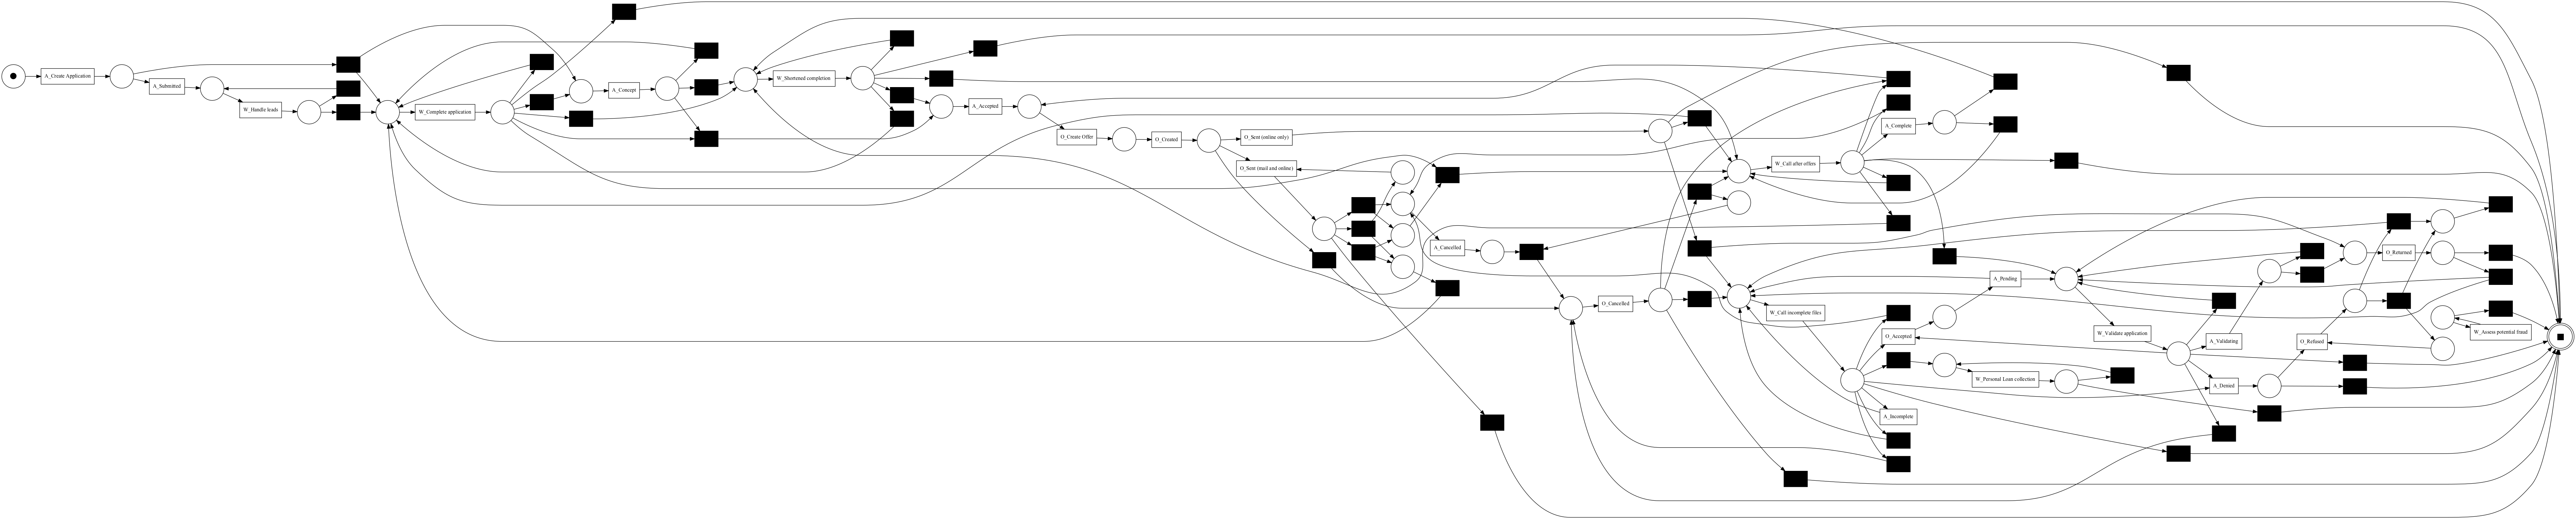

In [3]:
#Applying Heuristic miner to unfiltered event log, for comparison later
heu_net =  pm4py.discover_heuristics_net(log_concrete)
net_heu, im_heu, fm_heu = pm4py.convert_to_petri_net(heu_net)

pm4py.view_petri_net(net_heu, im_heu, fm_heu)

In [4]:
import numpy as np

def compute_case_duration(case):
    """Compute duration in seconds between first and last event in a pm4py Trace."""
    timestamps = [
        event["time:timestamp"]
        for event in case
        if "time:timestamp" in event
    ]
    if len(timestamps) < 2:
        return None
    return (max(timestamps) - min(timestamps)).total_seconds()


durations = []
for case in log_concrete:
    d = compute_case_duration(case)
    durations.append(d)

# Filtering out None and non-positive durations for calculation
dur_array = np.array([d for d in durations if d is not None and d > 0])

# Computing Confidence Interval
mean = dur_array.mean()
std = dur_array.std()

lower = mean - 1.96 * std
upper = mean + 1.96 * std

print("Mean:", mean)
print("Std:", std)
print("95% interval:", lower, upper)


# Filtering the Log 

time_filtered_log = []
for case, d in zip(log_concrete, durations):
    # Skip cases where duration could not be computed or is non-positive
    if d is None or d <= 0:
        continue
        
    # Check if duration falls within the 95% interval
    if lower <= d <= upper:
        # This line preserves the full trace object with all its attributes
        time_filtered_log.append(case) 

print("-" * 30)
print("Original log size:", len(log_concrete))
print("Filtered log size:", len(time_filtered_log))

Mean: 1892125.9230699483
Std: 1137803.6352294595
95% interval: -337969.2019797922 4122221.048119689
------------------------------
Original log size: 31509
Filtered log size: 30460


In [62]:
from pm4py.objects.log.obj import EventLog

variance_filtered_log =  pm4py.filter_variants_by_coverage_percentage(
    EventLog(time_filtered_log),
    0.0075,
)

print(len(variance_filtered_log))


4411


### Mining

Python(43253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


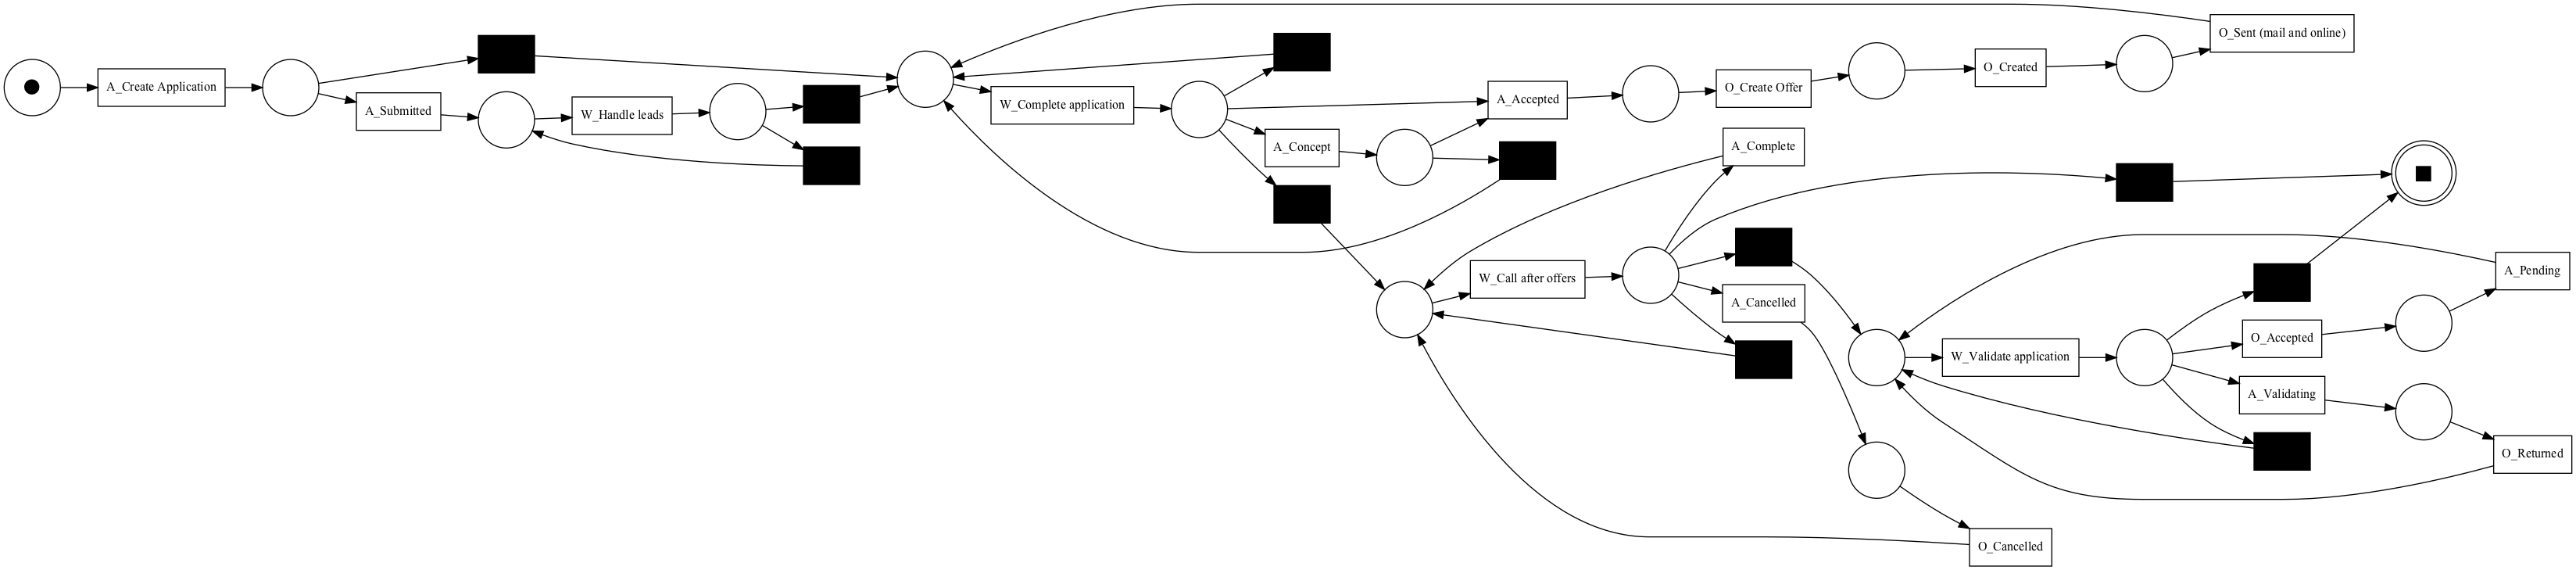

In [63]:
#Heuristic miner to filtered event log
heu_net_filtered =  pm4py.discover_heuristics_net(variance_filtered_log)
net_heu_fil, im_heu_fil, fm_heu_fil = pm4py.convert_to_petri_net(heu_net_filtered)

pm4py.view_petri_net(net_heu_fil,im_heu_fil, fm_heu_fil)

Python(43256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


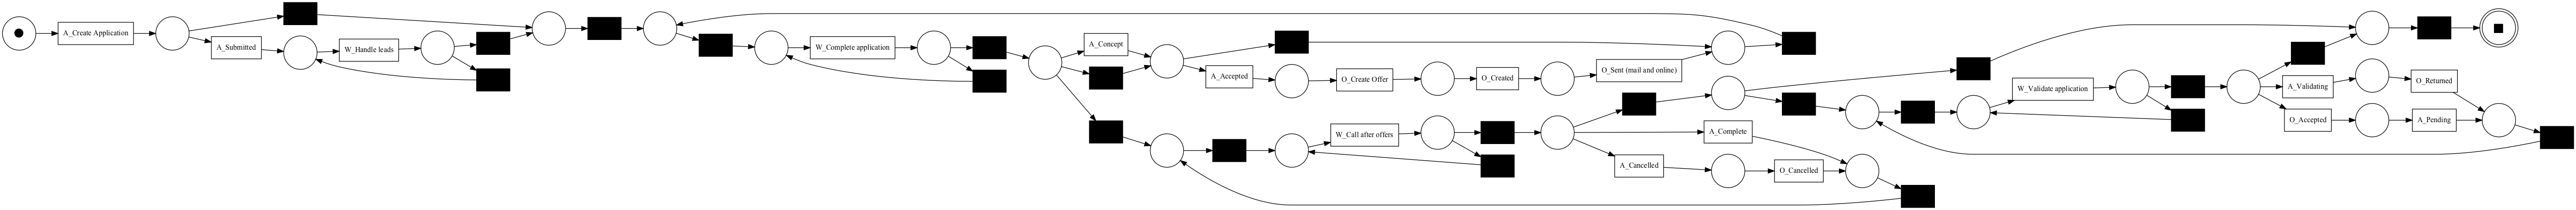

In [64]:
#Inductive miner to filtered event log
process_tree = pm4py.discover_process_tree_inductive(variance_filtered_log)
net_im_fil, im_im_fil, fm_im_fil = pm4py.convert_to_petri_net(process_tree)

pm4py.view_petri_net(net_im_fil, im_im_fil, fm_im_fil)

In [32]:
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# --- Individual Metric Methods (Returns FULL Dictionary) ---

def calculate_fitness(log, net, im, fm):
    print("Calc Fitness")
    fitness_results = fitness_evaluator.apply(
        log, net, im, fm,
        variant=fitness_evaluator.Variants.TOKEN_BASED
    )
    return fitness_results # Returns dictionary

def calculate_precision(log, net, im, fm):
    print("Calc Precision")
    precision_results = precision_evaluator.apply(
        log, net, im, fm,
        variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN
    )
    return precision_results # Returns dictionary

def calculate_generalization(log, net, im, fm):
    print("Calc Gen")
    generalization_results = generalization_evaluator.apply(log, net, im, fm)
    return generalization_results # Returns dictionary

def calculate_simplicity(net):
    print("Calc Simp")
    simplicity_results = simplicity_evaluator.apply(net)
    return simplicity_results # Returns dictionary (usually {'simplicity': score})

# --- Structural Complexity Methods (Returns Raw Integer/Float) ---

def calculate_raw_count(net):
    print("Calc Count")
    num_nodes = len(net.places) + len(net.transitions)
    num_arcs = len(net.arcs)
    return num_nodes + num_arcs

def calculate_cyclomatic_complexity(net):
    print("Calc Cyc")
    num_nodes = len(net.places) + len(net.transitions)
    num_arcs = len(net.arcs)
    return num_arcs - num_nodes + 1


In [33]:
# --- Overarching Method (Returns Tuple of Dictionaries and Integers) ---

def evaluate_model_quality(log, net, im, fm):
    
    # Calculate full result dictionaries
    fitness_dict = calculate_fitness(log, net, im, fm)
    precision_dict = calculate_precision(log, net, im, fm)
    generalization_dict = calculate_generalization(log, net, im, fm)
    simplicity_dict = calculate_simplicity(net) 
    
    # Calculate structural scores
    raw_count = calculate_raw_count(net)
    cyclomatic_complexity = calculate_cyclomatic_complexity(net)
    
    # Return all results
    return (
        fitness_dict, 
        precision_dict, 
        generalization_dict, 
        simplicity_dict, 
        raw_count, 
        cyclomatic_complexity
    )

In [54]:
fitness_dict_heu,  precision_dict_heu, generalization_dict_heu, simplicity_dict_heu, raw_count_heu, cyclomatic_complexity_heu = evaluate_model_quality(log_concrete,net_heu_fil, im_heu_fil, fm_heu_fil)

Calc Fitness


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Calc Precision


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

Calc Gen


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Calc Simp
Calc Count
Calc Cyc


In [55]:
fitness_dict_ind,  precision_dict_ind, generalization_dict_ind, simplicity_dict_ind, raw_count_ind, cyclomatic_complexity_ind = evaluate_model_quality(log_concrete,net_im_fil, im_im_fil, fm_im_fil)

Calc Fitness


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Calc Precision


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

Calc Gen


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Calc Simp
Calc Count
Calc Cyc


In [58]:

print("HEURISTICS MINER")
print(f"Fitness Dictionary (Heu): {fitness_dict_heu}") 
print(f"Precision Dictionary (Heu): {precision_dict_heu}")
print(f"Generalization Dictionary (Heu): {generalization_dict_heu}")
print(f"Simplicity Dictionary (Heu): {simplicity_dict_heu}")
print(f"Raw Count (Heu): {raw_count_heu}")
print(f"Cyclomatic Complexity (Heu): {cyclomatic_complexity_heu}")




print("\nINDUCTIVE MINER") 
print(f"Fitness Dictionary (Inductive): {fitness_dict_ind}") 
print(f"Precision Dictionary (Inductive): {precision_dict_ind}")
print(f"Generalization Dictionary (Inductive): {generalization_dict_ind}")
print(f"Simplicity Dictionary (Inductive): {simplicity_dict_ind}")
print(f"Raw Count (Inductive): {raw_count_ind}")
print(f"Cyclomatic Complexity (Inductive): {cyclomatic_complexity_ind}")



HEURISTICS MINER
Fitness Dictionary (Heu): {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9586234970644787, 'log_fitness': 0.9569356809557792, 'percentage_of_fitting_traces': 0.0}
Precision Dictionary (Heu): 0.6320925640841368
Generalization Dictionary (Heu): 0.9941860585711757
Simplicity Dictionary (Heu): 0.6619718309859156
Raw Count (Heu): 106
Cyclomatic Complexity (Heu): 13

INDUCTIVE MINER
Fitness Dictionary (Inductive): {'perc_fit_traces': 32.159065663778605, 'average_trace_fitness': 0.9783884509036189, 'log_fitness': 0.9767942745163924, 'percentage_of_fitting_traces': 32.159065663778605}
Precision Dictionary (Inductive): 0.5356115113644269
Generalization Dictionary (Inductive): 0.9944880651612672
Simplicity Dictionary (Inductive): 0.7499999999999999
Raw Count (Inductive): 156
Cyclomatic Complexity (Inductive): 13


### Process Model

Python(31039) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


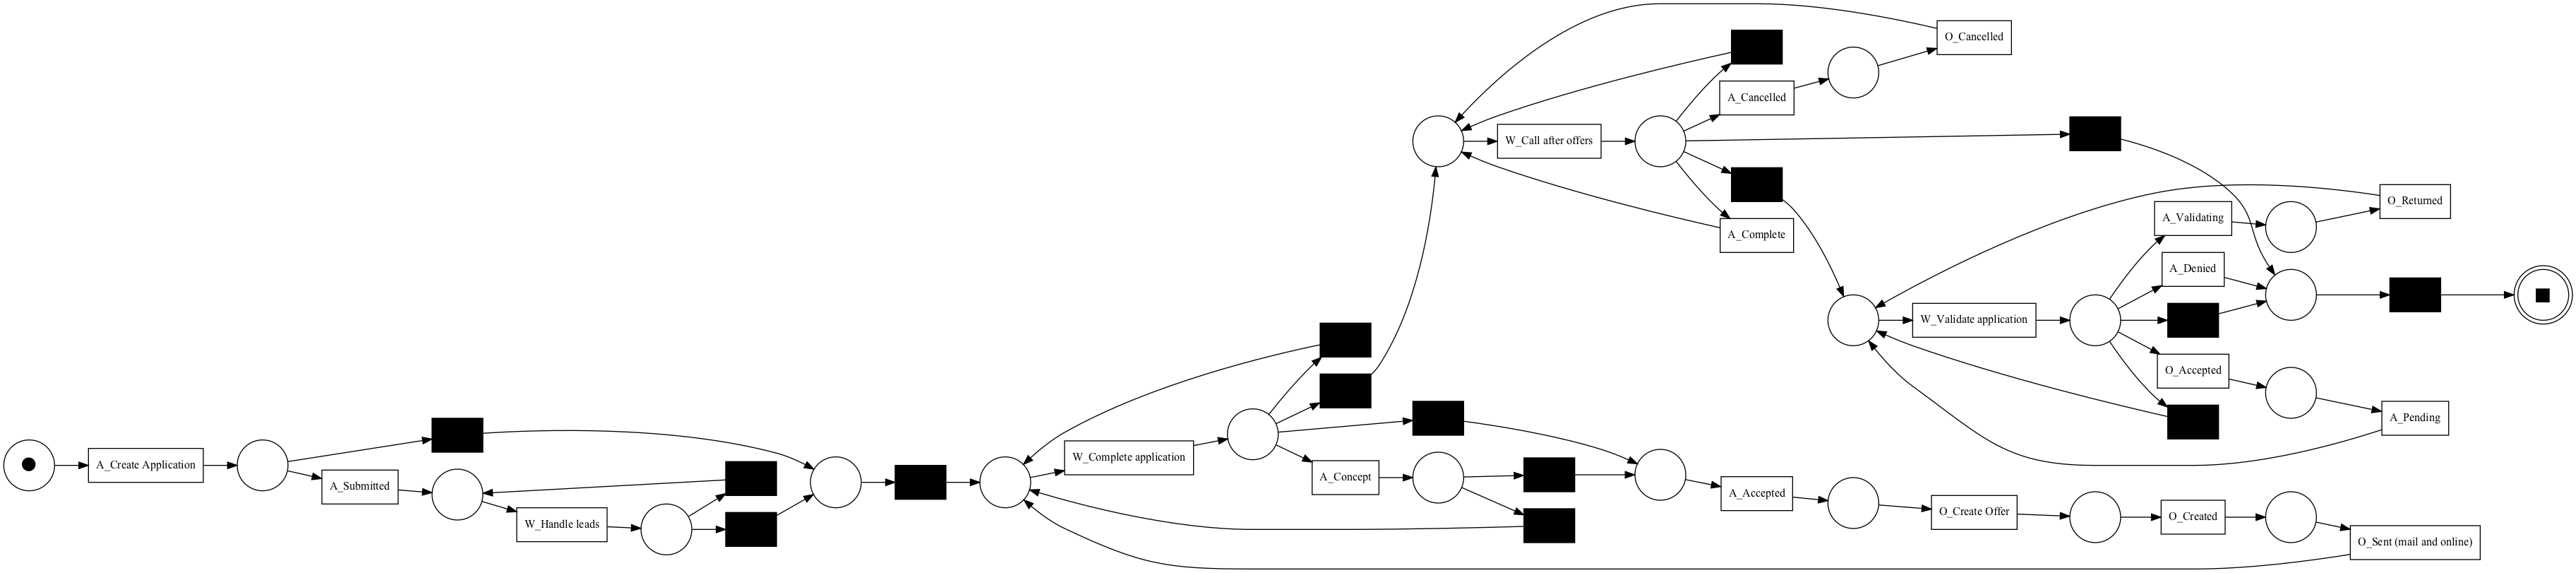

In [46]:
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

bpmn_model_17 = pm4py.read_bpmn('/Users/nick/BPPSO/BPMN_v2.bpmn')

net_heu_bfp, im_heu_bfp, fm_heu_bfp = pm4py.convert_to_petri_net(bpmn_model_17)

pm4py.view_petri_net(net_heu_bfp, im_heu_bfp, fm_heu_bfp)

In [47]:
transition_names_petri_net = [t.label for t in net_heu_fil.transitions if t.label is not None]
transition_names_bpmn = [t.label for t in net_heu_bfp.transitions if t.label is not None]

print(transition_names_petri_net)
print(transition_names_bpmn)


['A_Submitted', 'A_Cancelled', 'O_Created', 'O_Create Offer', 'O_Cancelled', 'A_Validating', 'A_Create Application', 'W_Handle leads', 'A_Concept', 'O_Returned', 'A_Pending', 'A_Complete', 'A_Accepted', 'W_Call after offers', 'W_Validate application', 'O_Sent (mail and online)', 'O_Accepted', 'W_Complete application']
['A_Accepted', 'O_Returned', 'O_Create Offer', 'O_Accepted', 'A_Pending', 'O_Sent (mail and online)', 'O_Cancelled', 'W_Call after offers', 'A_Denied', 'O_Created', 'W_Handle leads', 'A_Concept', 'A_Submitted', 'A_Cancelled', 'W_Complete application', 'A_Validating', 'A_Complete', 'A_Create Application', 'W_Validate application']


In [9]:
transition_names_petri_net = [t.label for t in net_heu_fil.transitions if t.label is not None]
transition_names_bpmn = [t.label for t in net_heu_bfp.transitions if t.label is not None]

print(transition_names_petri_net)
print(transition_names_bpmn)

['A_Submitted', 'A_Cancelled', 'O_Created', 'O_Create Offer', 'O_Cancelled', 'A_Validating', 'A_Create Application', 'W_Handle leads', 'A_Concept', 'O_Returned', 'A_Pending', 'A_Complete', 'A_Accepted', 'W_Call after offers', 'W_Validate application', 'O_Sent (mail and online)', 'O_Accepted', 'W_Complete application']
['A_Create Application', 'A_Complete', 'W_Validate application', 'A_Accepted', 'W_Call after offers', 'O_Create Offer', 'O_Accepted', 'O_Sent (mail and online)', 'O_Cancelled', 'O_Created', 'W_Handle leads', 'A_Concept', 'A_Submitted', 'A_Cancelled', 'O_Returned', 'W_Complete application', 'A_Validating', 'A_Pending']


Python(31042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


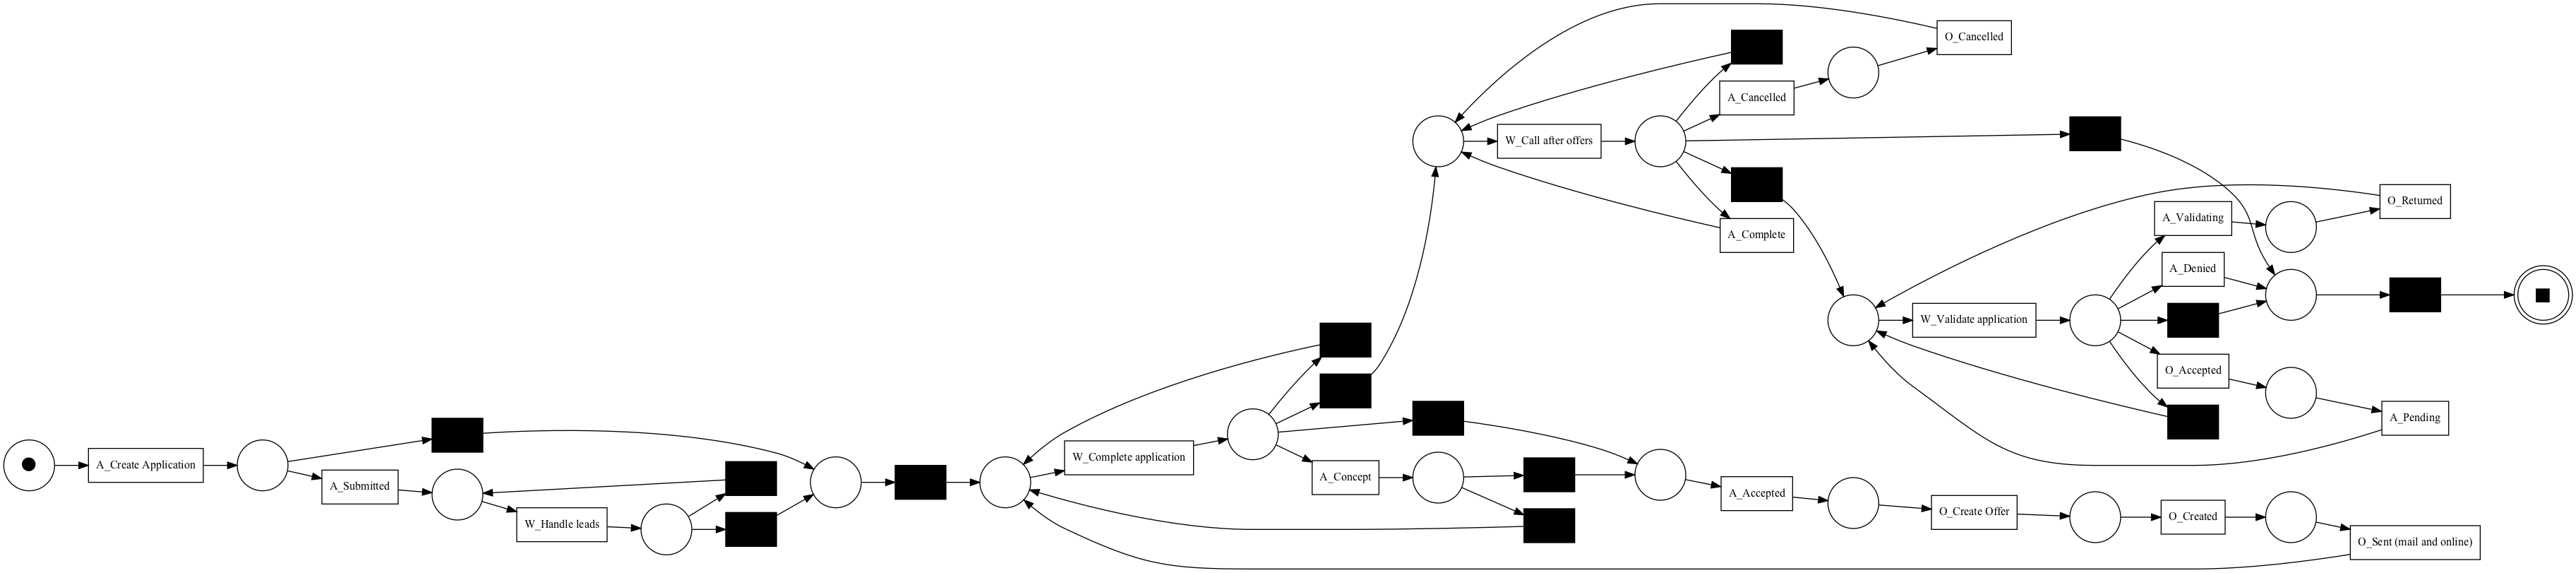

In [48]:
pm4py.view_petri_net(net_heu_bfp, im_heu_bfp, fm_heu_bfp)

In [60]:
fitness_dict_final,  precision_dict_final, generalization_dict_final, simplicity_dict_final, raw_count_final, cyclomatic_complexity_final = evaluate_model_quality(log_concrete,net_heu_bfp, im_heu_bfp, fm_heu_bfp)

Calc Fitness


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Calc Precision


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

Calc Gen


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:01<?, ?it/s]

Calc Simp
Calc Count
Calc Cyc


In [65]:
print("Final Model RESULTS")
 
print(f"Fitness Dictionary: {fitness_dict_final}") 
print(f"Precision Dictionary: {precision_dict_final}")
print(f"Generalization Dictionary: {generalization_dict_final}")
print(f"Simplicity Dictionary: {simplicity_dict_final}")
print(f"Raw Count: {raw_count_final}")
print(f"Cyclomatic Complexity: {cyclomatic_complexity_final}")


Final Model RESULTS
Fitness Dictionary: {'perc_fit_traces': 27.300136468945382, 'average_trace_fitness': 0.9697661309003769, 'log_fitness': 0.9673420917305693, 'percentage_of_fitting_traces': 27.300136468945382}
Precision Dictionary: 0.518196366961799
Generalization Dictionary: 0.9936517729657552
Simplicity Dictionary: 0.6790123456790124
Raw Count: 123
Cyclomatic Complexity: 14
